In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
!pip install kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle (3).json to kaggle (3).json


{'kaggle (3).json': b'{"username":"halaragab","key":"8ee67014a4e66ce89cebde875c53dfc1"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [5]:
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

Dataset URL: https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset
License(s): unknown
 87% 105M/121M [00:01<00:00, 98.1MB/s]
100% 121M/121M [00:01<00:00, 114MB/s] 


In [6]:
import zipfile
zip_ref = zipfile.ZipFile('/content/face-expression-recognition-dataset.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

In [7]:
train_dir = '/content/files/images/train'
val_dir = '/content/files/images/validation'

batch_size = 128
train_datagenerator = ImageDataGenerator()
validation_datagenerator = ImageDataGenerator()

train_set = train_datagenerator.flow_from_directory(train_dir,
                                                   target_size=(48, 48),
                                                   color_mode="grayscale",
                                                   class_mode="categorical",
                                                   batch_size=batch_size,
                                                   shuffle=True)
test_set = validation_datagenerator.flow_from_directory(val_dir,
                                                       target_size=(48, 48),
                                                       color_mode="grayscale",
                                                       class_mode="categorical",
                                                       batch_size=batch_size,
                                                       shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [8]:
def count_images_in_classes(path):
    classes = os.listdir(path)
    for c in classes:
        num_images = len(os.listdir(os.path.join(path, c)))
        print(f"Class {c}: {num_images} images")

# Count the number of images in each class for training, testing and validation sets
print("Train images:")
count_images_in_classes(train_dir)

print("\nValidation images:")
count_images_in_classes(val_dir)

Train images:
Class sad: 4938 images
Class neutral: 4982 images
Class happy: 7164 images
Class surprise: 3205 images
Class fear: 4103 images
Class angry: 3993 images
Class disgust: 436 images

Validation images:
Class sad: 1139 images
Class neutral: 1216 images
Class happy: 1825 images
Class surprise: 797 images
Class fear: 1018 images
Class angry: 960 images
Class disgust: 111 images


In [9]:
import tensorflow as tf
from tensorflow.keras import regularizers,layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam,SGD,RMSprop


classes = 7
model = Sequential()

#1st CNN layer
model.add(Conv2D(64, (3,3), padding="same", input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128, (5,5), padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#3rd CNN layer
model.add(Conv2D(512, (3,3), padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#4th CNN layer
model.add(Conv2D(512, (3,3), padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

#1st connected layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

#2nd connected layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(classes, activation='softmax'))

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

In [11]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
model_checkpoint = ModelCheckpoint("./model.h5",
                                   monitor="val_accuracy",
                                   verbose=1,
                                   save_best_only=True,
                                   mode="max")

early_stop = EarlyStopping(monitor="val_loss",
                           min_delta=0,
                           patience=3,
                           verbose=1,
                           restore_best_weights=True)

reduce_learning_rate = ReduceLROnPlateau(monitor="val_loss",
                                         factor=0.2,
                                         patience=3,
                                         verbose=1,
                                         min_delta=0.0001)

callbacks_list = [early_stop, model_checkpoint, reduce_learning_rate]
epochs = 48

In [12]:
history = model.fit(train_set,
                    epochs=epochs,
                    callbacks=callbacks_list,
                    validation_data=test_set,
                    steps_per_epoch=train_set.n//train_set.batch_size,
                    validation_steps=test_set.n//test_set.batch_size)

model.save("./emotion_detection_model.h5")

Epoch 1/48
225/225 [==============================] - ETA: 0s - loss: 2.0305 - accuracy: 0.2312
Epoch 1: val_accuracy improved from -inf to 0.31392, saving model to ./model.h5
225/225 [==============================] - 113s 490ms/step - loss: 2.0305 - accuracy: 0.2312 - val_loss: 1.7365 - val_accuracy: 0.3139 - lr: 1.0000e-04
Epoch 2/48


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


225/225 [==============================] - ETA: 0s - loss: 1.8189 - accuracy: 0.2980
Epoch 2: val_accuracy improved from 0.31392 to 0.33849, saving model to ./model.h5
225/225 [==============================] - 110s 487ms/step - loss: 1.8189 - accuracy: 0.2980 - val_loss: 1.6752 - val_accuracy: 0.3385 - lr: 1.0000e-04
Epoch 3/48
225/225 [==============================] - ETA: 0s - loss: 1.7115 - accuracy: 0.3436
Epoch 3: val_accuracy improved from 0.33849 to 0.36349, saving model to ./model.h5
225/225 [==============================] - 107s 476ms/step - loss: 1.7115 - accuracy: 0.3436 - val_loss: 1.6682 - val_accuracy: 0.3635 - lr: 1.0000e-04
Epoch 4/48
225/225 [==============================] - ETA: 0s - loss: 1.6322 - accuracy: 0.3757
Epoch 4: val_accuracy improved from 0.36349 to 0.39560, saving model to ./model.h5
225/225 [==============================] - 107s 475ms/step - loss: 1.6322 - accuracy: 0.3757 - val_loss: 1.6098 - val_accuracy: 0.3956 - lr: 1.0000e-04
Epoch 5/48
225/225

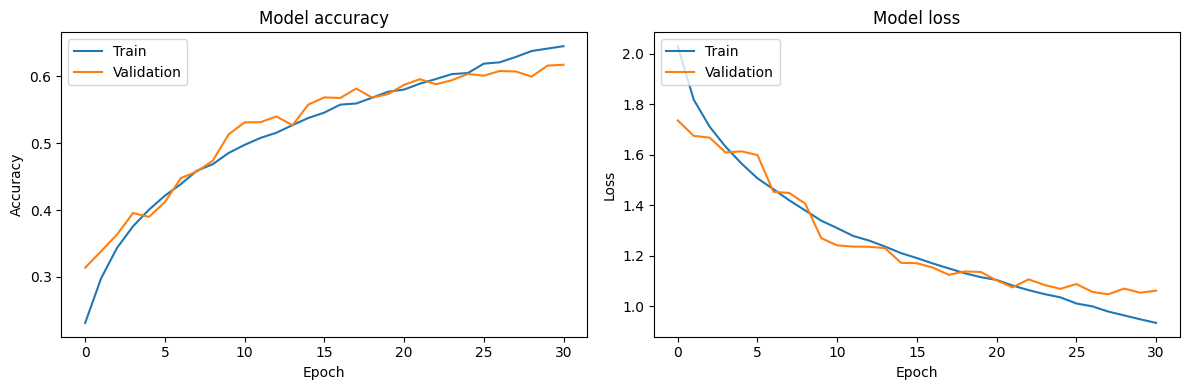

In [13]:

plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()